In [1]:
from ctt_and_rasch import *
from collections import OrderedDict
import matplotlib.pyplot as plt

def leer_estructura(archivo,col_comp='Competencia'):
    comp = {
        '011':'MAT',
        '014':'RED',
        '013':'LEC'
    }
    dti = pd.read_excel(archivo,skiprows=2,dtype={'Competencia':str,'Tema':str,'SubTema':str,'Categoria':str})
    dti['comp'] = dti[col_comp].apply(lambda x: comp[x])
    nitems = dti['comp'].value_counts().rename('nitems').to_dict()
    est = OrderedDict()
    for v in dti['comp'].unique():
        est[v] = nitems[v]
    return dti,est

def leer_respuestas(archivo,estructura,idlen=5):
    l = [(0,idlen)]
    start = idlen
    for v,numchars in estructura.items():
        l.append((start,start:=start+numchars))
    cols = ['EXAMEN'] + [k for k in estructura.keys()]
    df = pd.read_fwf(
        archivo,
        header=None,
        dtype=str,
        encoding='iso-8859-1',
        names= ['line'],
        widths= [start]
    )
    for (start,end),name in zip(l,cols):
        df[name] = df['line'].str[start:end]
    for col in cols[1:]:
        d = df[col].str.split(
            '',expand=True
        ).iloc[:,1:-1].rename(
            columns = lambda x: f'{col}{str(x).zfill(2)}'
        )
        df = df.drop(columns=[col]).join(d)
    return df.drop(columns=['line']).set_index('EXAMEN')

def leer_claves(path,colnames):
    clave = pd.read_excel(path).T
    clave.columns = colnames
    return clave.iloc[0]

def scatter_plot(x,y,labels,colors,cutoff=0.5):
    fig,ax = plt.subplots(figsize=(8,5))
    xvals = np.arange(np.min(x),np.max(x)+0.2,0.1)
    ax.set_xlabel("Dificultad estructura")
    ax.set_ylabel("Dificultad calulada")
    ax.scatter(x=x,y=y,c=colors,s=8)
    for xi,yi,text in zip(x,y,labels):
        ax.annotate(text=text,xy=(xi,yi),size=8)
    ax.plot(xvals,xvals,'-',color="gray")
    ax.fill_between(xvals,xvals - cutoff,xvals + cutoff,alpha=0.2)
    return fig

def analisisRasch(scored,est,estDTI):
    dif = {}
    hab = {}
    graphs = {}
    estDTI.index = scored.columns
    for v in est:
        dif[v],hab[v] = rasch(scored.filter(regex=f'{v}..'))
        #raschWinsteps(scored.filter(regex=f'{v}..'))
        b_calc = dif[v]['measure']
        b_ini = estDTI.loc[estDTI['comp']==v,'Medición']
        b_ini0 = b_ini - (b_ini[b_ini.notnull()].mean() - b_calc[b_ini.notnull()].mean())
        
        x = b_ini0[b_ini0.notnull()]
        y = b_calc[b_ini0.notnull()]
        
        keep = (np.abs(x-y) < 0.5).rename('keep')
        color = np.where(keep,"blue","red")

        # restar la media de los que queden anclados
        b_ini0 = pd.concat([b_ini0,keep],axis=1)
        diff_index = b_ini0['Medición'].notnull() & b_ini0['keep']
        diff = b_ini0.loc[diff_index,'Medición'].mean() - b_calc[diff_index].mean()
        b_calc = b_calc + diff + (b_ini[diff_index].mean()) - b_calc[diff_index].mean()
        #st.write(b_calc)
        
        graphs[v] = scatter_plot(x,y,x.index,color)
    return dif,hab,graphs

In [2]:
estDTI,est = leer_estructura('01153 Versión LETRAS.xls')
rsp = leer_respuestas('LETRAS.txt',estructura=est)
clave = leer_claves('CLAVE-LETRAS-1682440920.xlsx',colnames=rsp.columns)

In [3]:
scored = score(rsp,clave)

,score,count,measure,error,infit,zstdinfit,outfit,zstdoutfit
MAT01,60,229,0.403035,0.156695,0.995576,-0.034473,1.001317,0.049103
MAT02,64,229,0.306681,0.153758,1.132942,1.854948,1.175307,1.620890
MAT03,68,229,0.213706,0.151198,1.104506,1.577140,1.436869,3.972015
MAT04,91,229,-0.275983,0.141915,0.920767,-1.760066,0.894178,-1.585783
MAT05,75,229,0.057718,0.147490,0.964731,-0.597220,0.981280,-0.187159
MAT06,61,229,0.378600,0.155922,1.004223,0.081953,1.056962,0.544269
MAT07,73,229,0.101511,0.148458,0.991745,-0.118504,1.022799,0.281370
MAT08,35,229,1.130840,0.189274,1.064328,0.553653,1.111516,0.656615
MAT09,68,229,0.213706,0.151198,1.085540,1.302370,1.129421,1.302618
MAT10,56,229,0.503344,0.160070,1.047934,0.614848,0.995822,0.005280


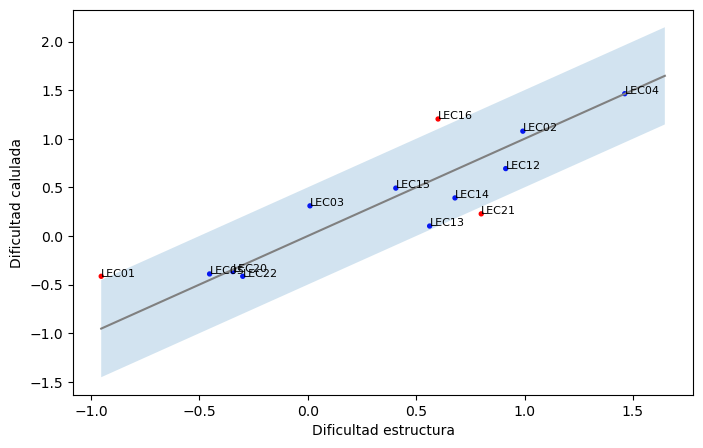

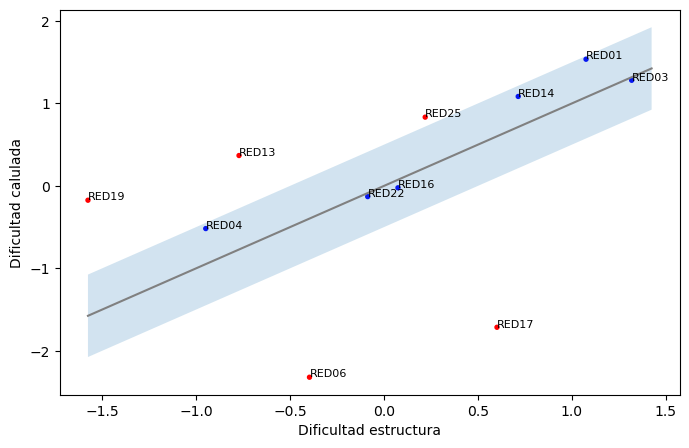

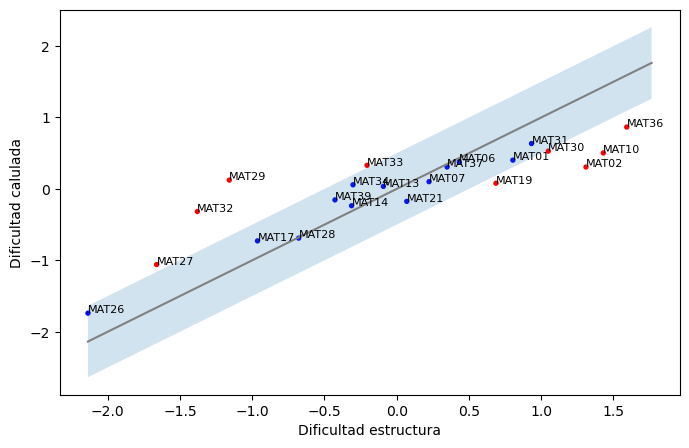

In [4]:
dif,hab,graph = analisisRasch(scored,est,estDTI)
dif['MAT']